[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/marharyta-aleksandrova/conformal-learning/blob/main/tutorials/Exercise_1._Testing_conformal_classifiers.ipynb)

Installing `nonconformist` library (uncomment the cells below)

In [1]:
# !git clone https://github.com/donlnz/nonconformist

In [2]:
# cd nonconformist

In [3]:
# !python setup.py install

# Imports

In [4]:
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.datasets import load_iris

from nonconformist.base import ClassifierAdapter
from nonconformist.icp import IcpClassifier
from nonconformist.nc import MarginErrFunc, InverseProbabilityErrFunc
from nonconformist.nc import ClassifierNc
from nonconformist.nc import NcFactory

from nonconformist.evaluation import cross_val_score
from nonconformist.evaluation import ClassIcpCvHelper
from nonconformist.evaluation import class_avg_c, class_mean_errors, class_one_c, class_one_err, \
    class_mean_errors_one_class, class_one_err_one_class, class_mean_p_val, class_empty, n_test

from sklearn.model_selection import KFold

import random

from sklearn.model_selection import StratifiedShuffleSplit
import pandas as pd
import matplotlib.pyplot as plt

Loading data

In [5]:
data = load_iris()

# Single run

Preparing data

In [6]:
np.random.seed(10)
random.seed(10)

# data permutation
idx = np.random.permutation(data['target'].size)
x, y = data['data'][idx, :], data['target'][idx]

# Divide the data into training set and test set (20% for test => 150*0.2 = 30, 120 for training)
test_len = int(len(data['target']) * 0.2)
x_test, y_test = x[:test_len, ], y[:test_len, ]

x_train_all, y_train_all = x[test_len:,], y[test_len:,]

# devide data into validation and proper training sets (25% for validation => 120 * 0.25 = 30)
# take only the 1st split
split = StratifiedShuffleSplit(n_splits=1, test_size=0.25)
for train, cal in split.split(np.zeros((y_train_all.size, 1)), y_train_all):
    break
    
x_cal, y_cal = x_train_all[cal,], y_train_all[cal,]
x_train, y_train = x_train_all[train,], y_train_all[train,]

Model fitting

In [7]:
model = RandomForestClassifier(n_estimators=100)
nc = NcFactory.create_nc(model)	# Create a default nonconformity function
icp = IcpClassifier(nc, smoothing=False)			# Create an inductive conformal classifier

# Fit the ICP using the proper training set
icp.fit(x_train, y_train)

# Calibrate the ICP using the calibration set
icp.calibrate(x_cal, y_cal)

# Produce predictions for the test set (generating p-values)
prediction_p = icp.predict(x_test)

# Print the first 5 predictions

Generating predictions for the required level of accuracy

In [8]:
prediction = prediction_p >= 0.1
print(prediction_p[:5, :])

[[0.03225806 0.16129032 0.06451613]
 [0.03225806 0.03225806 1.        ]
 [1.         0.03225806 0.03225806]
 [0.03225806 1.         0.03225806]
 [1.         0.03225806 0.03225806]]


# Cross validation

In [9]:
icp = IcpClassifier(ClassifierNc(ClassifierAdapter(RandomForestClassifier(n_estimators=100))), 
                    smoothing=False)
icp_cv = ClassIcpCvHelper(icp)

np.random.seed(10)
random.seed(10)

scores = cross_val_score(icp_cv,
                         data['data'],
                         data['target'],
                         iterations=1,
                         folds=5,
                         scoring_funcs=[
                             class_mean_errors,
                             class_avg_c,
                             class_one_c,
                             class_empty,
                         ],
                         significance_levels=[0.05, 0.1, 0.2],
                         verbose=True,
                         )

print('Classification: iris')

scores

iter 1/1 fold 5/5Classification: iris


,iter,fold,significance,class_mean_errors,class_avg_c,class_one_c,class_empty
0,0,0,0.05,0.000000,1.333333,0.800000,0.000000
1,0,0,0.10,0.000000,1.100000,0.933333,0.000000
2,0,0,0.20,0.200000,0.800000,0.800000,0.200000
3,0,1,0.05,0.033333,1.200000,0.866667,0.000000
4,0,1,0.10,0.100000,0.933333,0.933333,0.066667
5,0,1,0.20,0.233333,0.800000,0.800000,0.200000
6,0,2,0.05,0.033333,1.100000,0.933333,0.000000
7,0,2,0.10,0.100000,0.933333,0.933333,0.066667
8,0,2,0.20,0.133333,0.866667,0.866667,0.133333
9,0,3,0.05,0.000000,1.100000,0.933333,0.000000


Averaging results

In [10]:
scores = scores.drop(['fold', 'iter'], axis=1)
scores.groupby(['significance']).mean()

,class_mean_errors,class_avg_c,class_one_c,class_empty
significance,,,,
0.05,0.026667,1.140000,0.900000,0.006667
0.10,0.073333,0.966667,0.933333,0.053333
0.20,0.166667,0.840000,0.840000,0.160000


# Tasks:

1. Write functions for calculating `accuracy`, `avgC`, `oneC` and `emptyC`. Confirm that you get exacty the same results for the single run and for the 1st iteration of the 1st fold of cross-validation.
2. Try SVM instead of Random Forest `model = SVC(probability=True)`.
2. How do metrics depend on the number of folds and the number of iterations?
3. Repeat the analysis above for the dataset defined below.

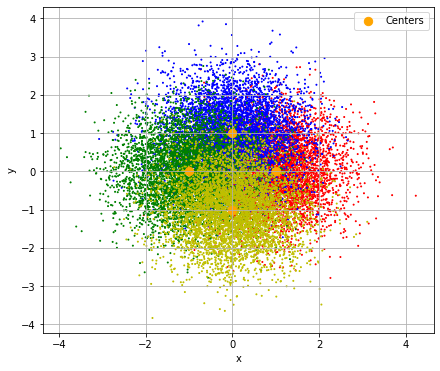

In [11]:
np.random.seed(20)
# centers of 4 classes
centers = [
    [ 1,  0],
    [ 0,  1],
    [-1,  0],
    [ 0, -1],
]

# colors to plot members of different classes
color_arr = ['r', 'b', 'g', 'y']

# number of instances per class
n_points = 5000
# these arrays will store information about datapoints
data_x = []
data_y = []
data_class = []
data_color = []

# standard deviation to generate the class instances
sigma = 0.8
# data generation
for class_val in range(0, len(centers)):
    x, y = centers[class_val]
    data_class.extend([class_val for j in range(0, n_points)])
    data_color.extend([color_arr[class_val] for j in range(0, n_points)])
    data_x.extend(np.random.normal(x, sigma, size=n_points))
    data_y.extend(np.random.normal(y, sigma, size=n_points))
# putting everything into a dataframe
data_df = pd.DataFrame({
    'x': data_x,
    'y': data_y,
    'class': data_class,
    'color': data_color,
})
# plotting the dataset
data_df.plot(
    kind='scatter',
    x='x',
    y='y',
    c=data_df['color'],
    s=1,
    grid=True,
    figsize=(7,6),
)

# showing the centers in orange
plt.scatter(np.array(centers).T[0], np.array(centers).T[1], s=70, c='orange', label='Centers')
plt.legend()
plt.show()

In [12]:
data = {'data': data_df[['x', 'y']].values, 'target': data_df['class'].values}
data

{'data': array([[ 1.70711449, -0.32341514],
        [ 1.15669202,  0.00971026],
        [ 1.28602921, -1.23900133],
        ...,
        [ 0.49568528, -0.83071061],
        [-0.40889864, -1.15983206],
        [-0.35289972, -1.00874749]]),
 'target': array([0, 0, 0, ..., 3, 3, 3], dtype=int64)}